В качестве домашнего задания мы предлагаем вам решить задачу бинарной классификации на большом корпусе imdb рецензий на фильмы. 
Корпус можно скачать по ссылке http://ai.stanford.edu/~amaas/data/sentiment/

Ваша задача в sklearn, используя три разных алгоритма, построить и обучить классификаторы, для каждого из них посчитать метрики качества. Постройте ROC кривую и посчитайте величину ROC AUC. Выберите лучший классификатор.

Используя предсказания вероятностей класса, найдите 15 самых негативных и самых позитивных рецензий по мнению модели.  - 7 баллов

Написать свои функции, которые бы считали tp, fp, tn, fn, и возвращали точность, полноту и ф-меру и применить их к результатам, полученным вашими классификаторами (если все сделано правильно, то результаты должны совпадать с полученными  sklearn метриками). - 3 балла

In [194]:
import os
import sys
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

from sklearn.metrics import roc_auc_score, roc_curve, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings('ignore')

In [195]:
def load_files(directory):
    sentences = []
    for file in os.listdir(directory):
        path = directory + '\\' + file
        with open(path, 'r', encoding='utf-8') as file:
            sentences.append(file.readlines()[0])
    return sentences
    

def read_texts(directory):
    
    directory = os.getcwd() + directory
    neg_directory = directory + '\\neg'
    pos_directory = directory + '\\pos'
    neg_sentences = load_files(neg_directory)
    pos_sentences = load_files(pos_directory)
    
    neg_index = np.arange(len(neg_sentences))
    pos_index = np.arange(len(neg_sentences), len(neg_sentences) + len(pos_sentences))
    
    neg_sentences = pd.Series(neg_sentences, index=neg_index)
    pos_sentences = pd.Series(pos_sentences, index=pos_index)
    
    sentences = pd.concat([neg_sentences, pos_sentences])
    sentiment_values = pd.concat([pd.Series(0, index=neg_index),
                                  pd.Series(1, index=pos_index)])
    
    df = pd.concat([sentences, sentiment_values], axis=1)
    df.columns = ['text', 'sentiment']
    
    return df

In [196]:
train_data = read_texts('\\aclImdb\\train')
#test_data = read_texts('\\aclImdb\\test')

In [232]:
train, test = train_test_split(train_data, test_size=0.2, random_state=0)

In [233]:
train.reset_index(inplace=True)

In [234]:
test.reset_index(inplace=True)

In [235]:
vec = TfidfVectorizer()
vec.fit(train.text.values)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [236]:
X_train = vec.transform(train.text)
X_test = vec.transform(test.text)

In [237]:
y_train = train.sentiment
y_test = test.sentiment

In [238]:
log_reg = LogisticRegression(solver='liblinear')
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier()

In [239]:
def eval_model(X_train, X_test, y_train, y_test, model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_pred)
    pr = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr, marker='.', label='Test')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    
    print('\n')
    print(f'f-score of the model is {f1}')
    print(f'ROC AUC score of the model is {roc}')
    print(f'Precision is {pr}')
    print(f'Recall is {rec}')
    print('\n\n\n')
    plt.show()
    
    return y_pred, y_pred_proba, f1, pr, rec



f-score of the model is 0.8864309697807624
ROC AUC score of the model is 0.8849821055541902
Precision is 0.876905041031653
Recall is 0.8961661341853036






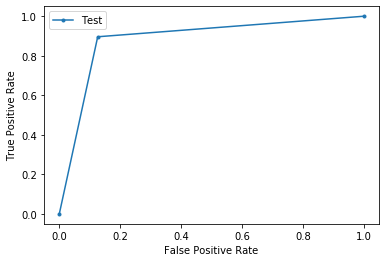

In [240]:
log_pred, log_pred_proba, log_f1, log_pr, log_rec = eval_model(X_train, X_test, y_train, y_test, log_reg)



f-score of the model is 0.7797348110033643
ROC AUC score of the model is 0.7773850301056769
Precision is 0.7728520988622989
Recall is 0.786741214057508






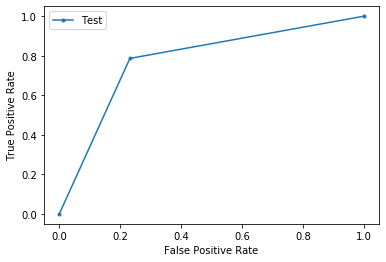

In [241]:
knn_pred, knn_pred_proba, knn_f1, knn_pr, knn_rec = eval_model(X_train, X_test, y_train, y_test, knn)



f-score of the model is 0.7147644391878573
ROC AUC score of the model is 0.7105784590808553
Precision is 0.7057220708446866
Recall is 0.7240415335463258






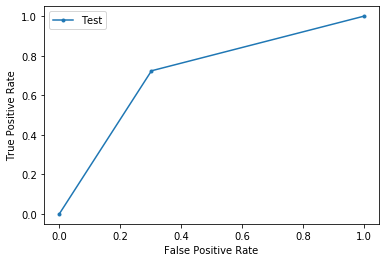

In [242]:
dt_pred, dt_pred_proba, dt_f1, dt_pr, dt_rec = eval_model(X_train, X_test, y_train, y_test, dt)

### Оценка моделей

Лучшим классификатором оказалась *логистическая регрессия*.

In [243]:
test['proba_0'] = log_pred_proba[:, 0]
test['proba_1'] = log_pred_proba[:, 1]

Самые негативные отзывы по мнению модели.

In [244]:
most_negative = test.sort_values(by='proba_0', ascending=False).head(15)
most_negative

,index,text,sentiment,proba_0,proba_1
73,11389,"When I rented this I was hoping for what ""Reig...",0,0.999207,0.000793
2575,8562,"I guess I've seen worse films, but that may be...",0,0.998933,0.001067
2667,11738,This movie was so bad! It was terrible! It was...,0,0.998637,0.001363
388,11563,Oh my GOD. I bought this movie and...I...watch...,0,0.998620,0.001380
4817,8173,"This was just horrible the plot was just OK, b...",0,0.998226,0.001774
187,9652,"This movie is an utter waste of time, the plot...",0,0.997816,0.002184
4672,2769,"Bad acting, bad lighting, bad plot!! This had ...",0,0.997792,0.002208
3930,2783,"The acting was bad, the script was bad and the...",0,0.997762,0.002238
3458,8835,i can't figure out who greenlighted this thing...,0,0.997588,0.002412
3985,10011,After a series of power-outages on a remote is...,0,0.997103,0.002897


Посмотрим на некоторые из них:

In [245]:
most_negative.sample(3).text.values

array(['This movie was so bad! It was terrible! It was awful! I cannot stress it enough! The acting, directing, story, characters and everything about it was bad! It was so corny and clichéd. Don\'t be fooled by the cover, or the tag line "The \'texas massacre\' is nothing to laugh at." Are you frogging\' kidding me! It was ridiculous.<br /><br />The first 2 minutes of the film is good until it gets to the main character Brendan, OK now turn it off. What I got from the film was, A bunch of ugly, annoying and immature people go to a cabin in the middle of the woods and a clown that sings nursery rhymes kills them in unoriginal and fake ways.<br /><br />This movie was a waste of my time and money, and it would be a waste of your money and time too! I fast forward through most of the movie because it was so terrible, I just wanted to see how each bad actor died, and it STILL wasn\'t worth it! Just looking at the cover is a waste of time. This IS seriously THE worst movie EVER! Rating: doe

Самые позитивные отзывы.

In [246]:
most_positive = test.sort_values(by='proba_1', ascending=False).head(15)
most_positive

,index,text,sentiment,proba_0,proba_1
3770,18680,If you have not seen this excellent movie abou...,1,0.001977,0.998023
3530,13356,"This movie has an all star cast, John Candy, R...",1,0.002623,0.997377
3275,21505,This is a taut suspenseful masterpiece from Br...,1,0.003043,0.996957
45,13420,I watched the movie in a preview and I really ...,1,0.003341,0.996659
308,15877,I love this film and it is such a wonderful ex...,1,0.004372,0.995628
1951,15030,"well, i said it all in the summary, i simpley ...",1,0.005224,0.994776
1818,21846,This is one of my favorite films of all time. ...,1,0.007261,0.992739
1713,20993,"For me,this is one of the best movies i ever s...",1,0.008021,0.991979
4990,21676,I thought this was a wonderful movie. It touch...,1,0.008201,0.991799
2778,13417,I have rarely emerged from viewing a film with...,1,0.008385,0.991615


In [247]:
most_positive.sample(3).text.values

array(['This movie has an all star cast, John Candy, Richard Lewis, Ornella Mutti, Cybill Shepard, and Jim Belushi to name a few, run amuck in Monte Carlo, as well as some other beautiful European locations, and is very funny. The trouble that everyone gets in when they lie to protect themselves is great, and I highly recommend that you see this movie, it is well worth it! John Candy is in top form in Once Upon A Crime, as is everyone else! If you and your family are looking for a great family film, this is your ticket. Everyone gives stellar performances, great acting, great comedy, and great timing, which is rare in movies these days. Great plot, great mystery, (which I love anyways) and overall, well worth the money you spend on it. So get the kids, grab some popcorn, juice, or tea, or sodas, and enjoy the show!!!!',
       'What can I say? An excellent end to an excellent series! It never quite got the exposure it deserved in Asia, but by far, the best cop show with the best writin

### Функции оценки качества предсказаний

In [248]:
def tp(true, pred):
    if true and pred:
        return True
    else:
        return False
def fp(true, pred):
    if not true and pred:
        return True
    else:
        return False
    
def tn(true, pred):
    if not true and not pred:
        return True
    else:
        return False

def fn(true, pred):
    if true and not pred:
        return True
    else:
        return False
    
def precision(tp, fp):
    return (tp)/(tp + fp)

def recall(tp, fn):
    return (tp)/(tp + fn)
    
def f1_custom(pr, rec):
    return (2 * pr * rec)/(pr + rec)  
    
def model_metrics(y_test, y_pred):
    assert len(y_test) == len(y_pred)
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    for i in range(len(y_test)):
        TP += tp(y_test[i], y_pred[i])
        FP += fp(y_test[i], y_pred[i])
        TN += tn(y_test[i], y_pred[i])
        FN += fn(y_test[i], y_pred[i])
    
    pr =  precision(TP, FP)
    rec = recall(TP, FN)
    f1 = f1_custom(pr, rec)
    
    return pr, rec, f1

def print_metrics(y_test, y_pred, true_pr, true_rec, true_f1):
    pr, rec, f1 = model_metrics(y_test.tolist(), y_pred)
    print('++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
    print(f'Custom function precision is {pr}, sklearn precision is {true_pr}.')
    print(f'These values are equal: {pr == true_pr}')
    print('++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
    print(f'Custom function recall is {rec}, sklearn recall is {true_rec}.')
    print(f'These values are equal: {rec == true_rec}')
    print('++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
    print(f'Custom function f-score is {f1}, sklearn f-score is {true_f1}.')
    print(f'These values are equal: {f1 == true_f1}')
    print('++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')

### Сравнение с библиотекой sklearn

*Logistic Regression*

In [249]:
print_metrics(y_test, log_pred, log_pr, log_rec, log_f1)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Custom function precision is 0.876905041031653, sklearn precision is 0.876905041031653.
These values are equal: True
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Custom function recall is 0.8961661341853036, sklearn recall is 0.8961661341853036.
These values are equal: True
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Custom function f-score is 0.8864309697807624, sklearn f-score is 0.8864309697807624.
These values are equal: True
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


*K-Nearest Neighbors*

In [250]:
print_metrics(y_test, knn_pred, knn_pr, knn_rec, knn_f1)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Custom function precision is 0.7728520988622989, sklearn precision is 0.7728520988622989.
These values are equal: True
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Custom function recall is 0.786741214057508, sklearn recall is 0.786741214057508.
These values are equal: True
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Custom function f-score is 0.7797348110033643, sklearn f-score is 0.7797348110033643.
These values are equal: True
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


*Decision Tree*

In [251]:
print_metrics(y_test, dt_pred, dt_pr, dt_rec, dt_f1)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Custom function precision is 0.7057220708446866, sklearn precision is 0.7057220708446866.
These values are equal: True
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Custom function recall is 0.7240415335463258, sklearn recall is 0.7240415335463258.
These values are equal: True
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Custom function f-score is 0.7147644391878573, sklearn f-score is 0.7147644391878573.
These values are equal: True
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
